## Identifying Duplicate Questions

Over 100 million people visit Quora every month, so it's no surprise that many people ask similar (or the same) questions. Various questions with the same intent can cause people to spend extra time searching for the best answer to their question, and results in members answering multiple versions of the same question. Quora uses random forest to identify duplicated questions to provide a better experience to active seekers and writers, and offer more value to both of these groups in the long term.
Follow the steps outlined below to build the appropriate classifier model. 


Steps:
- Download data
- Exploration
- Cleaning
- Feature Engineering
- Modeling

By the end of this project you should have **a presentation that describes the model you built** and its **performance**. 


In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import string
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import word_tokenize
from tqdm import tqdm
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from gensim.models import Word2Vec
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.ensemble import VotingClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense
from sklearn.model_selection import ParameterGrid
from joblib import Parallel, delayed
from sklearn.metrics import roc_curve, precision_recall_curve
from keras_tuner import HyperModel, RandomSearch
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model

In [4]:
quora_questions = pd.read_csv("/Users/brittanyharding/LHL-Projects/mini-project-V/train.csv")

In [12]:
# Display all the rows and columns
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# Display the full contents columns
pd.set_option('display.max_colwidth', None)

### Exploration

In [13]:
# Display the first few rows of the dataset
quora_questions.head(5)

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in share market in india?,What is the step by step guide to invest in share market?,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Diamond?,What would happen if the Indian government stole the Kohinoor (Koh-i-Noor) diamond back?,0
2,2,5,6,How can I increase the speed of my internet connection while using a VPN?,How can Internet speed be increased by hacking through DNS?,0
3,3,7,8,Why am I mentally very lonely? How can I solve it?,"Find the remainder when [math]23^{24}[/math] is divided by 24,23?",0
4,4,9,10,"Which one dissolve in water quikly sugar, salt, methane and carbon di oxide?",Which fish would survive in salt water?,0


In [14]:
quora_questions.tail(5)

,id,qid1,qid2,question1,question2,is_duplicate
404285,404285,433578,379845,How many keywords are there in the Racket programming language of the latest version?,How many keywords are there in PERL Programming Language in the latest version?,0
404286,404286,18840,155606,Do you believe there is life after death?,Is it true that there is life after death?,1
404287,404287,537928,537929,What is one coin?,What's this coin?,0
404288,404288,537930,537931,"What is the approx annual cost of living while studying in UIC Chicago, for an Indian student?","I am having little hairfall problem but I want to use hair styling product. Which one should I prefer out of gel, wax and clay?",0
404289,404289,537932,537933,What is like to have sex with cousin?,What is it like to have sex with your cousin?,0


#### Ground Truth Labels are inconsistent:

- When looking at the head and tail, there is a duplicated question for line 404289 - marked as not duplicate in the is_duplicate column
- Checked further for the first 100 rows - row 45 is marked as not duplicate when asking the same thing - except for the word quickly, yet row 65 is marked as a duplicate despite q1 asking a different first question before asking the matching second question
- I suspect the same thing for 62, as the timing would be referring to the same book by JK Rowling
- Row 66: asking similar but different things (best book ever made vs most important book you have ever read), yet marked as duplicate
- Row 77: How do I prevent breast cancer? vs Is breast cancer preventable? (marked as non-duplictae -> but more similar than other catergories marked as duplicate)

#### I suspect that there were multiple people doing the manual classification of the is_similar variable, and that they may not have had a clear guide as to how to determine what should vs should not have been classified as a duplicate.
```

### EDA

In [34]:
#Check Shape
quora_questions.shape

(404290, 6)

Total number of unique questions: 537933
Number of questions that appear multiple times: 111780


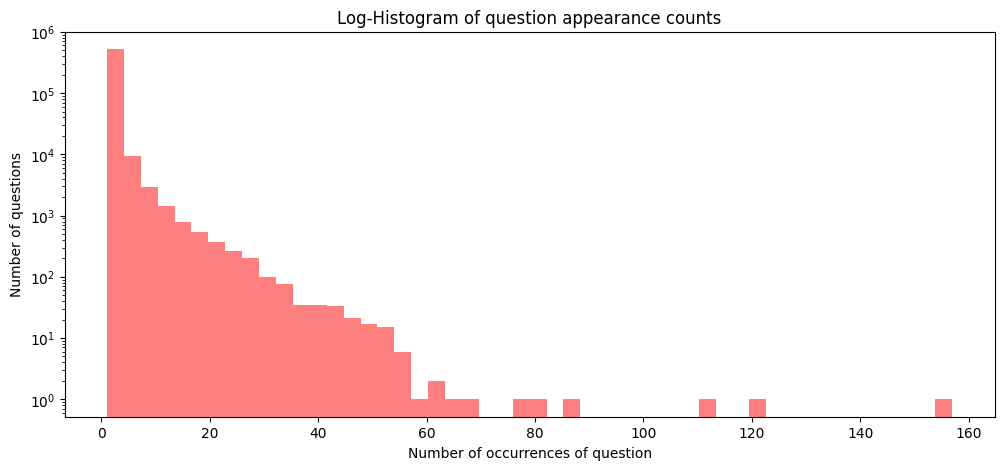

In [35]:
# Number of unique questions
unique_questions = pd.Series(quora_questions['qid1'].tolist() + quora_questions['qid2'].tolist())
print('Total number of unique questions:', len(np.unique(unique_questions)))

# Number of repeated questions
print('Number of questions that appear multiple times:', np.sum(unique_questions.value_counts() > 1))

# Histogram of question appearance counts
plt.figure(figsize=(12, 5))
plt.hist(unique_questions.value_counts(), bins=50, alpha=0.5, color= 'r', label='word in questions')
plt.yscale('log', nonpositive='clip')
plt.title('Log-Histogram of question appearance counts')
plt.xlabel('Number of occurrences of question')
plt.ylabel('Number of questions')
plt.show()

In [36]:
# Check for any null values
print("Number of null in question1: ", quora_questions['question1'].isnull().sum())
print("Number of null in question2: ", quora_questions['question2'].isnull().sum())

Number of null in question1:  1
Number of null in question2:  2


Class 0: 255027
Class 1: 149263
Proportion: 1.71 : 1


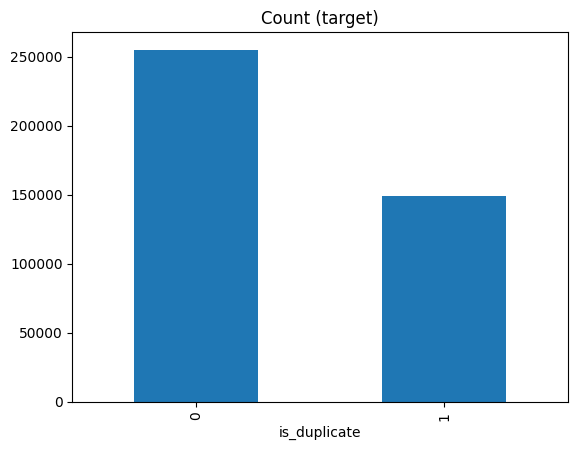

In [37]:
target_count = quora_questions['is_duplicate'].value_counts()
print('Class 0:', target_count[0])
print('Class 1:', target_count[1])
print('Proportion:', round(target_count[0] / target_count[1], 2), ': 1')

target_count.plot(kind='bar', title='Count (target)')
plt.show()

# Cleaning

In [38]:
tqdm.pandas()

def preprocess_all(quora_questions, column):
    # Create new column names for the preprocessed text
    new_column = 'preprocessed_' + column
    
    # Fill null values with empty strings
    quora_questions[column].fillna('', inplace=True)
    
    # Remove punctuation
    quora_questions[new_column] = quora_questions[column].progress_apply(lambda x: x.translate(str.maketrans("", "", string.punctuation)) if isinstance(x, str) else x)
    
    # Convert to lowercase
    quora_questions[new_column] = quora_questions[new_column].progress_apply(lambda x: x.lower() if isinstance(x, str) else x)

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    quora_questions[new_column] = quora_questions[new_column].progress_apply(lambda x: [word for word in x if word not in stop_words] if isinstance(x, list) else x)
    
    # Stem the tokens
    stemmer = PorterStemmer()
    quora_questions[new_column] = quora_questions[new_column].progress_apply(lambda x: [stemmer.stem(word) for word in x] if isinstance(x, list) else x)
    
    # Join the tokens back into a single string
    quora_questions[new_column] = quora_questions[new_column].progress_apply(lambda x: ' '.join(x) if isinstance(x, list) else x)
    
    
    return quora_questions

In [39]:
preprocess_all(quora_questions, 'question1')
preprocess_all(quora_questions, 'question2')

100%|██████████| 404290/404290 [00:00<00:00, 767608.35it/s]


,id,qid1,qid2,question1,question2,is_duplicate,preprocessed_question1,preprocessed_question2
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,what is the story of kohinoor kohinoor diamond,what would happen if the indian government sto...
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,how can i increase the speed of my internet co...,how can internet speed be increased by hacking...
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,why am i mentally very lonely how can i solve it,find the remainder when math2324math is divide...
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,which one dissolve in water quikly sugar salt ...,which fish would survive in salt water
...,...,...,...,...,...,...,...,...
404285,404285,433578,379845,How many keywords are there in the Racket prog...,How many keywords are there in PERL Programmin...,0,how many keywords are there in the racket prog...,how many keywords are there in perl programmin...
404286,404286,18840,155606,Do you believe there is life after death?,Is it true that there is life after death?,1,do you believe there is life after death,is it true that there is life after death
404287,404287,537928,537929,What is one coin?,What's this coin?,0,what is one coin,whats this coin
404288,404288,537930,537931,What is the approx annual cost of living while...,I am having little hairfall problem but I want...,0,what is the approx annual cost of living while...,i am having little hairfall problem but i want...


### Tokenisation
##### Kept separate to have both a preprocessed tokenised and preprocessed non-tokenised column to be able to run sentiment analysis off the whole questions

In [40]:
quora_questions['tokenised_question1'] = quora_questions['preprocessed_question1'].apply(nltk.word_tokenize)
quora_questions['tokenised_question2'] = quora_questions['preprocessed_question2'].apply(nltk.word_tokenize)

### Null Check

In [17]:
# Check for any null values
print("Number of null: ", quora_questions.isnull().sum())

In [16]:
# Drop rows where nulls appear in any column
quora_questions.dropna(inplace=True)

### Kernal keeps crashing due to memory limitations, updated CSV file to avoid need to repeat steps

In [43]:
# Export the DataFrame to a CSV file
quora_questions.to_csv('quora_questions_preprocessed.csv', index=False)

# Load the CSV file into a DataFrame
quora_questions = pd.read_csv('quora_questions_preprocessed.csv')


### Feature Engineering


### Create a new column cosine similarity and calculate the similarity for each question pair

In [44]:
# Extract tokenised question data
tokenised_question1 = quora_questions['tokenised_question1']
tokenised_question2 = quora_questions['tokenised_question2']

# Combine tokenised questions into a list
all_tokenised_questions = tokenised_question1 + tokenised_question2

# Create the TF-IDF vectoriser
TfidfVec = TfidfVectorizer(stop_words='english')

# Fit the vectoriser on the corpus
TfidfVec.fit(all_tokenised_questions)

def cos_similarity(text1, text2):
    tfidf = TfidfVec.transform([text1, text2])
    return (tfidf * tfidf.T).toarray()[0, 1]  # Return the cosine similarity between text1 and text2


In [45]:
# Create a new column 'cosine_similarity' and calculate the similarity for each pair
quora_questions['cosine_similarity'] = quora_questions.progress_apply(
    lambda row: cos_similarity(row['tokenised_question1'], row['tokenised_question2']), axis=1)

100%|██████████| 404290/404290 [16:51<00:00, 399.68it/s]


### Kernal keeps crashing due to memory limitations, updated CSV file to avoid need to repeat steps

In [46]:
# Export the DataFrame to a CSV file
quora_questions.to_csv('quora_questions_cosine_similarity.csv', index=False)

# Load the CSV file into a DataFrame
quora_questions = pd.read_csv('quora_questions_cosine_similarity.csv')


### Create column for Common Words to Measure Semantic Similarity:

In [47]:
# Calculate Common Words
quora_questions['common_words'] = quora_questions.apply(lambda row: len(set(row['tokenised_question1']).intersection(set(row['tokenised_question2']))), axis=1)

### Create columns for Length and Word Count Analysis:

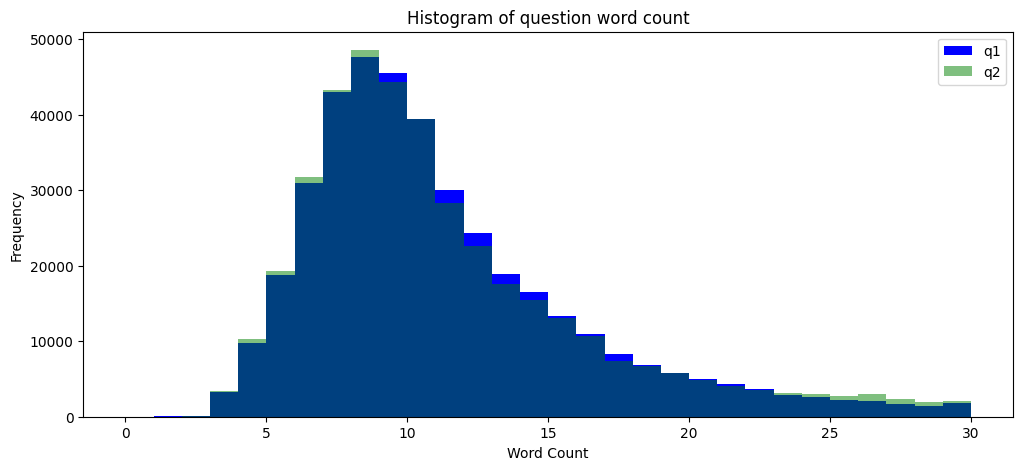

In [48]:
quora_questions['q1_len'] = quora_questions['question1'].str.len()
quora_questions['q2_len'] = quora_questions['question2'].str.len()

quora_questions['q1_word_count'] = quora_questions['question1'].apply(lambda x: len(str(x).split()))
quora_questions['q2_word_count'] = quora_questions['question2'].apply(lambda x: len(str(x).split()))

plt.figure(figsize=(12, 5))
plt.hist(quora_questions['q1_word_count'], bins=30, range=[0, 30], color='blue', label='q1')
plt.hist(quora_questions['q2_word_count'], bins=30, range=[0, 30], color='green', alpha=0.5, label='q2')
plt.title('Histogram of question word count')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.legend()
plt.show()

### Create column with Length Difference to measure the absolute difference in the lengths of preprocessed_question1 and preprocessed_question2:

In [49]:
quora_questions['length_difference'] = abs(quora_questions['preprocessed_question1'].str.len() - quora_questions['preprocessed_question2'].str.len())

In [57]:
from gensim.models import Word2Vec
import numpy as np

# Combine tokenised data from preprocessed_question1 and preprocessed_question2
tokenised_data = quora_questions['preprocessed_question1'].apply(lambda x: x.split()) + \
                 quora_questions['preprocessed_question2'].apply(lambda x: x.split())

# Train the word2vec model on the combined tokenised data
word2vec_model = Word2Vec(tokenised_data, vector_size=100, window=5, min_count=1, workers=4)

# Save the trained model
word2vec_model.save('word2vec.bin')

# Load the trained Word2Vec model
word2vec_model = Word2Vec.load('word2vec.bin')

# Apply Word2Vec embeddings to the preprocessed_question1 column
quora_questions['word2vec_question1'] = quora_questions['preprocessed_question1'].apply(
    lambda x: np.mean([word2vec_model.wv[word] for word in x.split()], axis=0)
)

# Apply Word2Vec embeddings to the preprocessed_question2 column
quora_questions['word2vec_question2'] = quora_questions['preprocessed_question2'].apply(
    lambda x: np.mean([word2vec_model.wv[word] for word in x.split()], axis=0)
)


### Create column with Jaccard Similarity to measure the overlap or similarity between two sets by calculating the size of the intersection divided by the size of the union of elements in the sets:

In [58]:
def jaccard_similarity(row):
    words_question1 = set(row['preprocessed_question1'].split())
    words_question2 = set(row['preprocessed_question2'].split())
    intersection = words_question1.intersection(words_question2)
    union = words_question1.union(words_question2)
    return len(intersection) / len(union)

quora_questions['jaccard_similarity'] = quora_questions.apply(jaccard_similarity, axis=1)

### Again, updated CSV file to avoid losing work from kernel crashes

In [59]:
# Export the DataFrame to a CSV file
quora_questions.to_csv('quora_questions_jaccard.csv', index=False)

# Load the CSV file into a DataFrame
quora_questions = pd.read_csv('quora_questions_jaccard.csv')


### Create column with Levenshtein Distance as a measure of dissimilarity calculating the minimum number of single-character edits (insertions, deletions, or substitutions) required to transform one string into another:

In [60]:
from Levenshtein import distance as levenshtein_distance

quora_questions['levenshtein_distance'] = quora_questions.apply(
    lambda x: levenshtein_distance(x['preprocessed_question1'], x['preprocessed_question2']), axis=1
)


### Create Column with shared_bigrams and shared_trigrams to obtain a measure of similarity based on the overlapping sequences of words:

In [61]:
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np

def shared_ngrams(q1, q2, n):
    vectorizer = CountVectorizer(ngram_range=(n, n))
    if q1 == "NA" or q2 == "NA":
        return 0
    try:
        counts = vectorizer.fit_transform([q1, q2])
        return np.sum(np.minimum(counts.toarray()[0], counts.toarray()[1]))
    except ValueError:
        return 0

quora_questions['preprocessed_question1'] = quora_questions['preprocessed_question1'].apply(lambda x: x if isinstance(x, str) else "NA")
quora_questions['preprocessed_question2'] = quora_questions['preprocessed_question2'].apply(lambda x: x if isinstance(x, str) else "NA")

quora_questions['shared_bigrams'] = quora_questions.apply(lambda row: shared_ngrams(row['preprocessed_question1'], row['preprocessed_question2'], 2), axis=1)
quora_questions['shared_trigrams'] = quora_questions.apply(lambda row: shared_ngrams(row['preprocessed_question1'], row['preprocessed_question2'], 3), axis=1)

### Again, updated CSV file to avoid losing work from kernel crashes

In [62]:
# Export the DataFrame to a CSV file
quora_questions.to_csv('quora_questions_fe_complete.csv', index=False)

### Create column with sentiment analysis scores for capturing sentiment similarity between question pairs

In [63]:
from tqdm import tqdm
from nltk.sentiment import SentimentIntensityAnalyzer
import nltk
import pandas as pd

tqdm.pandas()

nltk.download('vader_lexicon')

def get_sentiment(df, column, output_column):
    sia = SentimentIntensityAnalyzer()

    def get_score(text):
        sentiment = sia.polarity_scores(text)
        return sentiment['compound'] 

    df[output_column] = df[column].progress_apply(get_score)

    return df

# Apply sentiment analysis to 'question1' and 'question2'
quora_questions = get_sentiment(quora_questions, 'question1', 'sentiment1')
quora_questions = get_sentiment(quora_questions, 'question2', 'sentiment2')


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/brittanyharding/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
100%|██████████| 404273/404273 [01:27<00:00, 4636.47it/s]


### Create column with TF-IDF Vectors for Question Pairs to Capture Textual Similarity

In [64]:
# Create an instance of TfidfVectoriser
tfidf_vectorizer = TfidfVectorizer()

# Fit and transform question1 column
tfidf_question1 = tfidf_vectorizer.fit_transform(quora_questions['question1'])

# Transform question2 column
tfidf_question2 = tfidf_vectorizer.transform(quora_questions['question2'])

# Convert to sparse vectors
tfidf_question1 = tfidf_question1.toarray()
tfidf_question2 = tfidf_question2.toarray()

# Create new columns in the DataFrame with the TF-IDF vectors
quora_questions['tfidf_question1'] = list(tfidf_question1)
quora_questions['tfidf_question2'] = list(tfidf_question2)

### Create column with GloVe-based Cosine Similarity for Sentence Pairs to Measure Semantic Similarity.

In [65]:
import torch
from torchtext.vocab import GloVe
from tqdm import tqdm
import pandas as pd

# Load GloVe embeddings
embedding_glove = GloVe(name='6B', dim=100)

def compute_sentence_vector(sentence, embedding):
    words = sentence.split()
    vectors = [embedding[word] for word in words if word in embedding.stoi]
    
    if vectors:
        return torch.mean(torch.stack(vectors), dim=0)
    else:
        return torch.zeros(embedding.dim)

def cosine_similarity(vec1, vec2):
    dot_product = torch.dot(vec1, vec2)
    norm_vec1 = torch.norm(vec1)
    norm_vec2 = torch.norm(vec2)
    
    return dot_product / (norm_vec1 * norm_vec2)

# Assuming you have a pandas DataFrame named quora_questions with columns question1 and question2
similarities = []

for _, row in tqdm(quora_questions.iterrows(), total=quora_questions.shape[0]):
    vector1 = compute_sentence_vector(row['question1'], embedding_glove)
    vector2 = compute_sentence_vector(row['question2'], embedding_glove)
    similarity = cosine_similarity(vector1, vector2).item()
    similarities.append(similarity)

quora_questions['gloVe similarity'] = similarities


100%|██████████| 404273/404273 [02:25<00:00, 2775.35it/s]


### Again, updated CSV file to avoid losing work from kernel crashes

In [66]:
# Export the DataFrame to a CSV file
quora_questions.to_csv('quora_questions_fe_additions.csv', index=False)

# Load the CSV file into a DataFrame
quora_questions = pd.read_csv('quora_questions_fe_additions.csv')

### Split Data with full FE features into 90% training and 10% test
##### Plan to train/test 3 models with the 90% and then test the best model with the remaining 10%

In [68]:
from sklearn.model_selection import train_test_split

# Split the dataset into training set (90%) and testing set (10%)
quora_questions_train, quora_questions_test = train_test_split(quora_questions, test_size=0.1, random_state=42)

# Export the separated dataframes to .csv files
quora_questions_train.to_csv('quora_questions_train.csv', index=False)
quora_questions_test.to_csv('quora_questions_test.csv', index=False)

# Modeling

The different modeling techniques I used:

- logistic regression
- Keras Neural Network
- Ensemble Model: RandomForest, Gradient Boost, and Logistic Regression

Kept the features used consistent across models to best determine accuracy of each model. However, I applied different hyperparamter tuning methods to be able to test them out.
Based on computer memory, I needed to limit features I was able to use across models.

In [3]:
# Load the CSV file into a DataFrame
quora_questions_train = pd.read_csv('quora_questions_train.csv')

# Model 1 - Logistic Regression

In [72]:
# Selecting columns to use as features in the model
features = quora_questions_train[['cosine_similarity', 'common_words', 'q1_len',
       'sentiment1', 'sentiment2', 'q2_len', 'q1_word_count', 'q2_word_count',
       'length_difference', 'jaccard_similarity', 'levenshtein_distance',
       'shared_bigrams', 'shared_trigrams']]


# Selecting the target variable
target = quora_questions_train['is_duplicate']


# Splitting data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Creating logistic regression model
log_reg = LogisticRegression(solver='liblinear')

# Training the model
log_reg.fit(X_train, y_train)

# Predicting the test set results
y_pred = log_reg.predict(X_test)

# Printing evaluation metrics
print("Classification Report:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("Accuracy Score:")
print(accuracy_score(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.80      0.77     45941
           1       0.60      0.51      0.55     26828

    accuracy                           0.69     72769
   macro avg       0.67      0.66      0.66     72769
weighted avg       0.69      0.69      0.69     72769

Confusion Matrix:
[[36769  9172]
 [13057 13771]]
Accuracy Score:
0.6945265154117825


In [20]:
# Define the hyperparameters
param_grid = {
    'C': np.logspace(-4, 4, 20),
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear']
}

# Create a list of all combinations of hyperparameters
all_params = list(ParameterGrid(param_grid))

# Define a function to train a model and compute its cross-validation score
def evaluate_model(params):
    model = LogisticRegression(**params)
    return cross_val_score(model, X_train, y_train, cv=5).mean()

# Evaluate all combinations of hyperparameters
cv_scores = Parallel(n_jobs=-1)(
    delayed(evaluate_model)(params) for params in tqdm(all_params)
)

# Get the best parameters
best_params = all_params[np.argmax(cv_scores)]
print("Best Parameters: ", best_params)

# Train your model using the best parameters
log_reg = LogisticRegression(**best_params)
log_reg.fit(X_train, y_train)

# Predicting the test set results
y_pred = log_reg.predict(X_test)

# Printing evaluation metrics
print("Classification Report:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("Accuracy Score:")
print(accuracy_score(y_test, y_pred))

100%|██████████| 40/40 [15:26<00:00, 23.17s/it]


Best Parameters:  {'C': 206.913808111479, 'penalty': 'l2', 'solver': 'liblinear'}
Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.80      0.77     45941
           1       0.60      0.51      0.55     26828

    accuracy                           0.69     72769
   macro avg       0.67      0.66      0.66     72769
weighted avg       0.69      0.69      0.69     72769

Confusion Matrix:
[[36787  9154]
 [13069 13759]]
Accuracy Score:
0.69460896810455


### Visualise Metrics

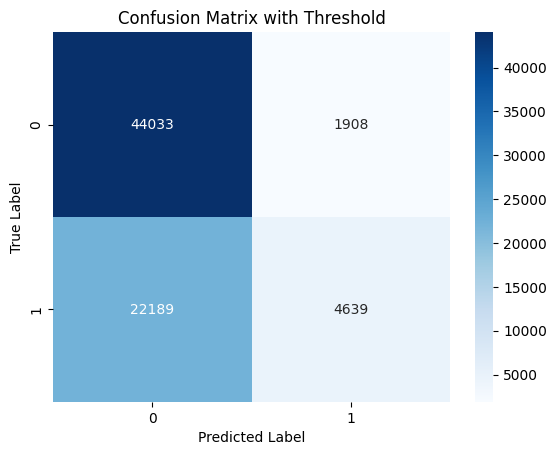

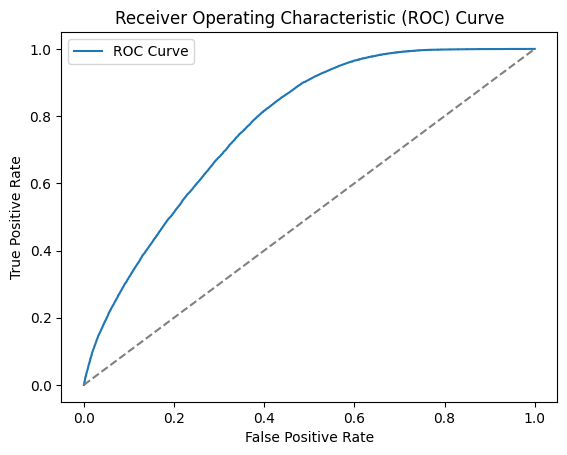

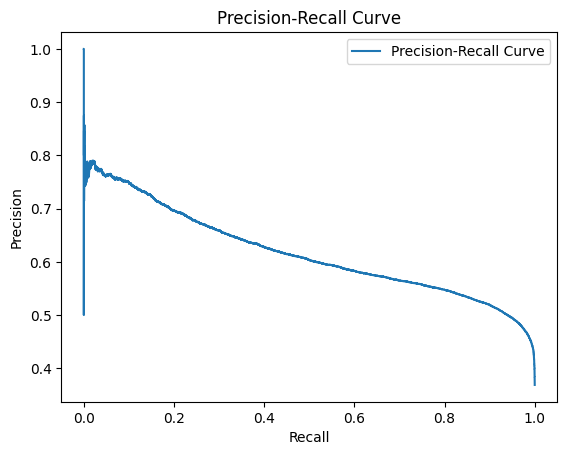

In [22]:
# Confusion Matrix
confusion_mat = confusion_matrix(y_test, y_pred_threshold)
sns.heatmap(confusion_mat, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix with Threshold")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.plot(fpr, tpr, label="ROC Curve")
plt.plot([0, 1], [0, 1], linestyle="--", color="grey")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend()
plt.show()

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
plt.plot(recall, precision, label="Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.show()

### Logistic Regression - Grid Search Hyperparameter Tuning

In [ ]:
# Define the hyperparameters
param_grid = {
    'C': np.logspace(-4, 4, 20),
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear']
}

# Create a list of all combinations of hyperparameters
all_params = list(ParameterGrid(param_grid))

# Define a function to train a model and compute its cross-validation score
def evaluate_model(params):
    model = LogisticRegression(**params)
    return cross_val_score(model, X_train, y_train, cv=5).mean()

# Evaluate all combinations of hyperparameters
cv_scores = Parallel(n_jobs=-1)(
    delayed(evaluate_model)(params) for params in tqdm(all_params)
)

# Get the best parameters
best_params = all_params[np.argmax(cv_scores)]
print("Best Parameters: ", best_params)

# Train your model using the best parameters
log_reg = LogisticRegression(**best_params)
log_reg.fit(X_train, y_train)

# Predicting the test set results
y_pred = log_reg.predict(X_test)

# Printing evaluation metrics
print("Classification Report:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("Accuracy Score:")
print(accuracy_score(y_test, y_pred))

# Plotting the confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", cbar=False,
            annot_kws={"size": 12}, linewidths=0.5)
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Confusion Matrix")
plt.show()

# Model 2 -  Keras Neural Network

In [37]:
# Selecting features to use in the model
test_features_selected = test_features[['cosine_similarity', 'common_words', 'q1_len', 'q2_len', 'q1_word_count', 'q2_word_count',
                                      'length_difference', 'jaccard_similarity', 'levenshtein_distance',
                                      'shared_bigrams', 'shared_trigrams', 'sentiment1', 'sentiment2']]

target = quora_questions_train['is_duplicate']

# Standardise the features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Splitting data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(features_scaled, target, test_size=0.2, random_state=42)

# Define model
model = Sequential()

# Add the input layer
model.add(Dense(units=128, activation='relu', input_dim=features_scaled.shape[1]))

# Add a hidden layer
model.add(Dense(units=64, activation='relu'))

# Add output layer
model.add(Dense(units=1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Fit the model to the training data
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test), verbose=1)


Epoch 1/10
9097/9097 [==============================] - 51s 5ms/step - loss: 0.4894 - accuracy: 0.7307 - val_loss: 0.4785 - val_accuracy: 0.7382
Epoch 2/10
9097/9097 [==============================] - 39s 4ms/step - loss: 0.4793 - accuracy: 0.7389 - val_loss: 0.4754 - val_accuracy: 0.7409
Epoch 3/10
9097/9097 [==============================] - 40s 4ms/step - loss: 0.4752 - accuracy: 0.7408 - val_loss: 0.4718 - val_accuracy: 0.7437
Epoch 4/10
9097/9097 [==============================] - 45s 5ms/step - loss: 0.4720 - accuracy: 0.7435 - val_loss: 0.4711 - val_accuracy: 0.7445
Epoch 5/10
9097/9097 [==============================] - 46s 5ms/step - loss: 0.4696 - accuracy: 0.7453 - val_loss: 0.4734 - val_accuracy: 0.7425
Epoch 6/10
9097/9097 [==============================] - 45s 5ms/step - loss: 0.4674 - accuracy: 0.7479 - val_loss: 0.4730 - val_accuracy: 0.7453
Epoch 7/10
9097/9097 [==============================] - 36s 4ms/step - loss: 0.4658 - accuracy: 0.7490 - val_loss: 0.4677 - val_ac

In [40]:
# Save the trained model
model.save("keras_model_1.h5")

# Load the saved model
loaded_model = load_model("keras_model_1.h5")

### Metrics

2275/2275 [==============================] - 6s 3ms/step - loss: 0.4693 - accuracy: 0.7454
Test Loss: 0.46932926774024963
Test Accuracy: 0.7453860640525818
2275/2275 [==============================] - 5s 2ms/step


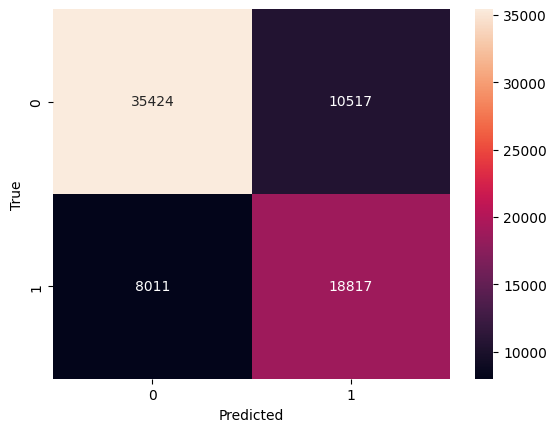

              precision    recall  f1-score   support

           0       0.82      0.77      0.79     45941
           1       0.64      0.70      0.67     26828

    accuracy                           0.75     72769
   macro avg       0.73      0.74      0.73     72769
weighted avg       0.75      0.75      0.75     72769



In [15]:
# Evaluate the model on the test data
loss, accuracy = model.evaluate(X_test, y_test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

# Make predictions on the test data
y_pred = model.predict(X_test)

# Convert the predicted probabilities to binary values
y_pred_binary = (y_pred > 0.5).astype(int)

# Create confusion matrix
cm = confusion_matrix(y_test, y_pred_binary)

# Create a heatmap of the confusion matrix
sns.heatmap(cm, annot=True, fmt="d")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Create classification report
report = classification_report(y_test, y_pred_binary)
print(report)


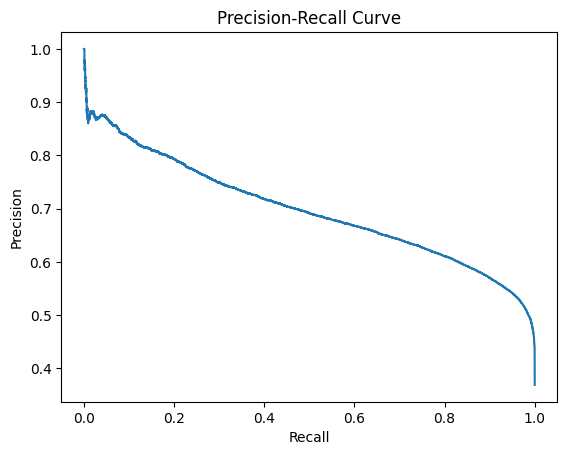

In [17]:
# Calculate precision and recall
precision, recall, thresholds = precision_recall_curve(y_test, y_pred)

# Plot the precision-recall curve
plt.figure()
plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

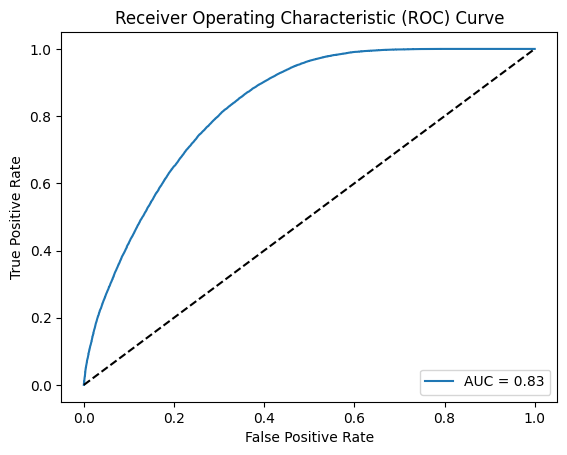

In [18]:
# Calculate the false positive rate (FPR) and true positive rate (TPR)
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

# Calculate the Area Under the Curve (AUC)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

### Test hyperparameters using Keras HyperModelBuilder

In [48]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from keras_tuner import HyperModel, RandomSearch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Define the HyperModelBuilder class
class HyperModelBuilder(HyperModel):
    
    def __init__(self, X_train, y_train):
        self.X_train = X_train
        self.y_train = y_train
    
    # Build method to construct and compile the neural network
    def build(self, hp):
        model = Sequential()
        model.add(Dense(units=hp.Int('input_units', min_value=64, max_value=256, step=32),
                        activation='relu', input_dim=self.X_train.shape[1]))
        model.add(Dense(units=hp.Int('hidden_units', min_value=32, max_value=128, step=32), activation='relu'))
        model.add(Dense(units=1, activation='sigmoid'))
        
        model.compile(optimizer=Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
                      loss='binary_crossentropy', metrics=['accuracy'])
        
        return model

# Standardize the features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(features_scaled, target, test_size=0.2, random_state=42)

# Instantiate the HyperModelBuilder class
hypermodel = HyperModelBuilder(X_train, y_train)

# Set up the tuner using the RandomSearch algorithm
tuner = RandomSearch(
    hypermodel,
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial=1,
    directory='random_search',
    project_name='quora_questions'
)

# Start the hyperparameter search
tuner.search(X_train, y_train, epochs=10, validation_data=(X_test, y_test), verbose=1)


Trial 10 Complete [00h 03m 27s]
val_accuracy: 0.741249680519104

Best val_accuracy So Far: 0.7496873736381531
Total elapsed time: 00h 49m 28s
INFO:tensorflow:Oracle triggered exit


In [49]:
# Load the best model
best_model = tuner.get_best_models(num_models=1)[0]

# Make predictions on the test dataset
y_pred = best_model.predict(X_test)

2275/2275 [==============================] - 4s 2ms/step


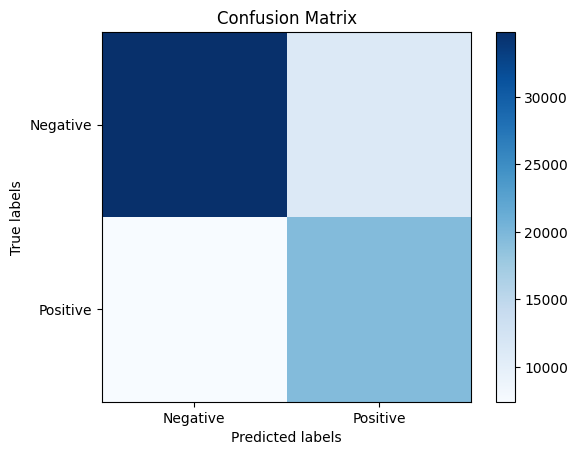

In [11]:
# Convert the predicted probabilities to binary labels
y_pred_labels = np.round(y_pred)

# Plot a confusion matrix
cm = confusion_matrix(y_test, y_pred_labels)
plt.imshow(cm, cmap=plt.cm.Blues)
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.xticks([0, 1], ['Negative', 'Positive'])
plt.yticks([0, 1], ['Negative', 'Positive'])
plt.title("Confusion Matrix")
plt.colorbar()
plt.show()


# Model 3 - Ensemble Model

In [12]:
# Step 1: Selecting columns to use as features in the model
features = quora_questions_train[['cosine_similarity', 'common_words', 'q1_len',
       'sentiment1', 'sentiment2', 'q2_len', 'q1_word_count', 'q2_word_count',
       'length_difference', 'jaccard_similarity', 'levenshtein_distance',
       'shared_bigrams', 'shared_trigrams']]


# Step 2: Selecting the target variable
target = quora_questions_train['is_duplicate']


# Step 3: Splitting data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Step 4: Scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 5: Train multiple models
model1 = RandomForestClassifier() 
model2 = GradientBoostingClassifier()
model3 = LogisticRegression(solver='lbfgs', max_iter=1000)


# Step 6: Create an ensemble by combining the models
ensemble = VotingClassifier(estimators=[('rf', model1), ('gb', model2), ('lr', model3)], voting='hard')

# Step 7: Perform cross-validation
scores = cross_val_score(ensemble, X_train, y_train, cv=5) 

# Step 8: Print cross-validation scores
print("Cross-Validation Scores:", scores)
print("Mean CV Score:", scores.mean())

# Step 9: Fit the ensemble model on the full training data
ensemble.fit(X_train, y_train)

# Step 10: Make predictions on the test data
y_pred = ensemble.predict(X_test)

# Step 11: Error analysis
print("Classification Report:")
print(classification_report(y_test, y_pred))

Cross-Validation Scores: [0.74005428 0.74035901 0.74367431 0.74042772 0.74118354]
Mean CV Score: 0.741139774785603
Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.80      0.80     45941
           1       0.66      0.64      0.65     26828

    accuracy                           0.74     72769
   macro avg       0.72      0.72      0.72     72769
weighted avg       0.74      0.74      0.74     72769



In [19]:
def objective(trial):
    # Define the parameters' range
    rf_n_estimators = trial.suggest_int('rf_n_estimators', 10, 200)
    rf_max_depth = trial.suggest_int('rf_max_depth', 1, 30)
    gb_n_estimators = trial.suggest_int('gb_n_estimators', 10, 200)
    gb_learning_rate = trial.suggest_uniform('gb_learning_rate', 0.001, 0.2)
    lr_C = trial.suggest_uniform('lr_C', 0.001, 1)

    # Create the models with suggested parameters
    model1 = RandomForestClassifier(n_estimators=rf_n_estimators, max_depth=rf_max_depth)
    model2 = GradientBoostingClassifier(n_estimators=gb_n_estimators, learning_rate=gb_learning_rate)
    model3 = LogisticRegression(C=lr_C)

    ensemble = VotingClassifier(estimators=[('rf', model1), ('gb', model2), ('lr', model3)], voting='hard')

    # Train and evaluate the model
    scores = cross_val_score(ensemble, X_train_scaled, y_train, cv=5)
    return scores.mean()

# Create a study object and optimize the objective function
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=5)

# Print the best parameters and best score
print("Best Parameters:", study.best_params)
print("Best Score:", study.best_value)

[I 2023-06-07 19:05:08,651] A new study created in memory with name: no-name-69b9fdfa-9ea8-4d3f-9e5c-6badd913984b
/var/folders/mh/gw7ldp_51fq3fsmcfkh4750w0000gn/T/ipykernel_883/2067972048.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  gb_learning_rate = trial.suggest_uniform('gb_learning_rate', 0.001, 0.2)
/var/folders/mh/gw7ldp_51fq3fsmcfkh4750w0000gn/T/ipykernel_883/2067972048.py:7: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  lr_C = trial.suggest_uniform('lr_C', 0.001, 1)
[I 2023-06-07 19:10:51,460] Trial 0 finished with value: 0.7295173744608672 and parameters: {'rf_n_estimators': 73, 'rf_max_depth': 27, 'gb_n_estimators': 15, 'gb_learning_rate': 0.17329223056959017, 'lr_C': 0.032812727062309775

Best Parameters: {'rf_n_estimators': 41, 'rf_max_depth': 30, 'gb_n_estimators': 138, 'gb_learning_rate': 0.04947395605398757, 'lr_C': 0.5691359143336557}
Best Score: 0.7370308779426923


### Rerunning model based on best parameters

In [20]:
# Step 1: Selecting columns to use as features in the model
features = quora_questions_train[['cosine_similarity', 'common_words', 'q1_len',
       'sentiment1', 'sentiment2', 'q2_len', 'q1_word_count', 'q2_word_count',
       'length_difference', 'jaccard_similarity', 'levenshtein_distance',
       'shared_bigrams', 'shared_trigrams']]

# Step 2: Selecting the target variable
target = quora_questions_train['is_duplicate']

# Step 3: Splitting data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Step 4: Scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 5: Train the models with the best parameters
model1 = RandomForestClassifier(n_estimators=41, max_depth=30)
model2 = GradientBoostingClassifier(n_estimators=138, learning_rate=0.04947395605398757)
model3 = LogisticRegression(solver='lbfgs', max_iter=1000, C=0.5691359143336557)

# Step 6: Create an ensemble by combining the models
ensemble = VotingClassifier(estimators=[('rf', model1), ('gb', model2), ('lr', model3)], voting='hard')

# Step 7: Fit the ensemble model on the full training data with best parameters
ensemble.fit(X_train_scaled, y_train)

# Step 8: Make predictions on the test data
y_pred = ensemble.predict(X_test_scaled)

# Step 9: Error analysis
print("Classification Report:")
print(classification_report(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.80      0.79     45941
           1       0.65      0.63      0.64     26828

    accuracy                           0.74     72769
   macro avg       0.72      0.71      0.72     72769
weighted avg       0.74      0.74      0.74     72769



### Review Metrics

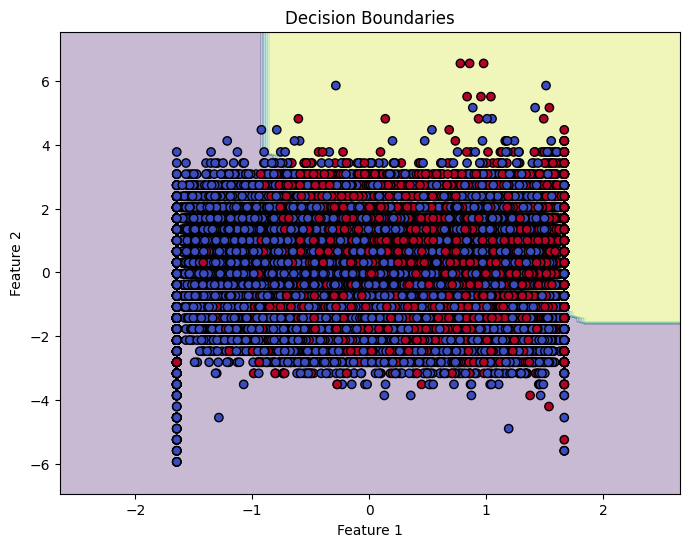

In [32]:
# Step 1: Define the range of values for the features
x_min, x_max = X_train_scaled[:, 0].min() - 1, X_train_scaled[:, 0].max() + 1
y_min, y_max = X_train_scaled[:, 1].min() - 1, X_train_scaled[:, 1].max() + 1

# Step 2: Generate a meshgrid of points within the feature range
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))

# Step 3: Prepare dummy features for the remaining 11 features
dummy_features = np.zeros_like(xx)
extra_feature1 = np.zeros_like(xx)  # Assign zero values to extra_feature1
extra_feature2 = np.zeros_like(xx)  # Assign zero values to extra_feature2

# Step 4: Concatenate the features to create the meshgrid input
X_meshgrid = np.c_[xx.ravel(), yy.ravel(), dummy_features.ravel(), dummy_features.ravel(),
                   dummy_features.ravel(), dummy_features.ravel(), dummy_features.ravel(),
                   dummy_features.ravel(), dummy_features.ravel(), dummy_features.ravel(),
                   dummy_features.ravel(), extra_feature1.ravel(), extra_feature2.ravel()]

# Step 5: Predict the class labels for each point in the meshgrid using the trained ensemble model
Z = ensemble.predict(X_meshgrid)
Z = Z.reshape(xx.shape)

# Step 6: Plot the decision boundaries and the training data
plt.figure(figsize=(8, 6))
plt.contourf(xx, yy, Z, alpha=0.3)
plt.scatter(X_train_scaled[:, 0], X_train_scaled[:, 1], c=y_train, cmap='coolwarm', edgecolor='k')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Decision Boundaries')
plt.show()


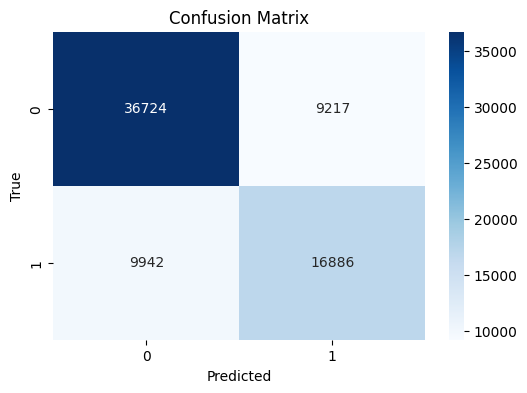

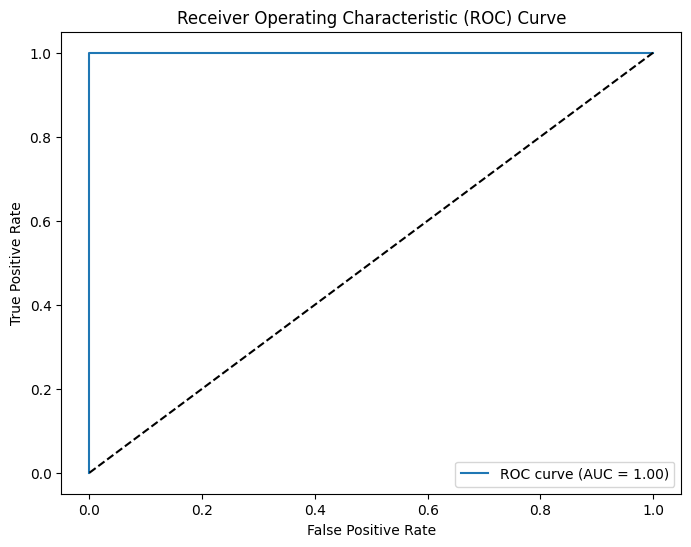

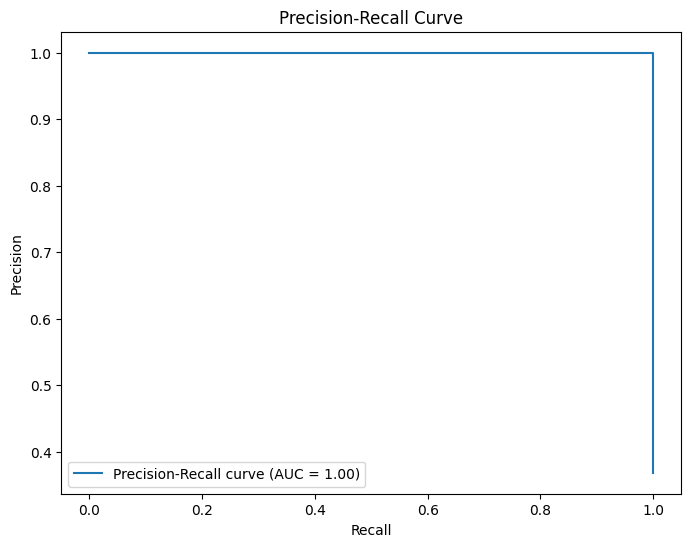

In [33]:
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_curve, auc, precision_recall_curve

# Step 6: Visualise confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Step 5: Compute ROC curve and AUC
fpr, tpr, thresholds_roc = roc_curve(y_test, y_test)
roc_auc = auc(fpr, tpr)

# Step 6: Compute precision-recall curve and AUC
precision, recall, thresholds_pr = precision_recall_curve(y_test, y_test)
pr_auc = auc(recall, precision)

# Step 7: Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='ROC curve (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# Step 8: Plot precision-recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label='Precision-Recall curve (AUC = {:.2f})'.format(pr_auc))
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.show()

# Testset - Running Most Successful Model - Keras NN on testset

In [34]:
# Load Test Data
quora_questions_test = pd.read_csv('quora_questions_test.csv')

# Create a separate DataFrame for test features without the target column
test_features = quora_questions_test.drop('is_duplicate', axis=1)

In [55]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

# Convert test_features_selected to a DataFrame
test_features_selected = pd.DataFrame(test_features_selected, columns=feature_names)

# Create a new StandardScaler object
scaler_test = StandardScaler()

# Fit the scaler on the training data
scaler_test.fit(X_train)

# Transform the test features using the fitted scaler object
test_features_scaled = scaler_test.transform(test_features_selected)

# Make predictions on the test dataset
test_predictions = best_model.predict(test_features_scaled)


   1/1264 [..............................] - ETA: 1:04

/Users/brittanyharding/anaconda3/lib/python3.10/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


1264/1264 [==============================] - 4s 3ms/step


In [58]:
from sklearn.metrics import accuracy_score

# Convert the test predictions to binary values
binary_predictions = (test_predictions > 0.5).astype(int)

# Compare the binary predicted values with the actual target values
accuracy = accuracy_score(actual_target, binary_predictions)

# Print the accuracy
print("Accuracy:", accuracy)


Accuracy: 0.46893242307311767


This model performed significantly worse on the test set than the training set, would need to explore further to figure out why. However, reasons could include:
- Insufficient training data
- Complex model architecture
- Need for further of regularization
- Data quality issues
- Class imbalance or data distribution mismatch